# Aim

The aim of the anaylsis is to investigate the stability of cNE patterns in spantaneous activities and stimulus-driven activities. 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
%matplotlib inline

from scipy import signal, stats
from scipy.stats import zscore

from helper import chi_square
from plot_box import plot_significance_star

# get colors for box plots
colors = sns.color_palette("Paired")
A1_color = (colors[1], colors[0], colors[3], colors[2])
MGB_color = (colors[5], colors[4], colors[7], colors[6])
colors_split = [colors[i] for i in [3, 2, 7, 6, 9, 8]]


In [2]:
def plot_sig_corr_distribution(df):
    bins=np.linspace(0.5, 1, 21)
    g = sns.FacetGrid(df, col="stim", hue="region", palette=[MGB_color[0], A1_color[0]], height=5)
    g.map(plt.hist, 'corr', bins=bins, ec='k', alpha=0.6, density=True)
    axes = g.axes[0]
    for ax in axes:
        ax.set_xlabel('| correlation |')
        title = ax.get_title()
        stim = title[7:]
        ax.set_title(stim)
        n_ne_sig = np.empty(2)
        n_ne = np.empty(2)
        for i, region in enumerate(('MGB', 'A1')):
            corr_sig = df[(df.stim == stim) & (df.region == region)]['corr_sig']
            ratio = corr_sig.mean()
            n_ne_sig[i] = corr_sig.sum()
            n_ne[i] = len(corr_sig)
            ax.text(0.5, 4 -  i, '{:.1f}%'.format(ratio*100), color=eval('{}_color[0]'.format(region)))
        
        _, p = chi_square(n_ne_sig, n_ne)
        ax.text(0.5, 2, 'p = {:.3f}'.format(p), color='k')

    axes[-1].legend()
    axes[0].set_yticks(range(0, 7, 2))
    axes[0].set_yticklabels(map(lambda x: '{:.2f}'.format(x), np.arange(0, 0.2, 0.05)))
    axes[0].set_ylabel('ratio')
    
    # print result of significance test for proportions
    for region in ('MGB', 'A1'):
    
        print(region)
        dmr = df[(df.stim == 'dmr') & (df.region == region)]['corr_sig'].apply((sum, len))
        spon = df[(df.stim == 'spon') & (df.region == region)]['corr_sig'].apply((sum, len))
        cross = df[(df.stim == 'cross') & (df.region == region)]['corr_sig'].apply((sum, len))
    
        print('dmr vs spon: p = {:.4f}'.format(chi_square([dmr[0], spon[0]], [dmr[1], spon[1]])[1]))
        print('dmr vs cross: p = {:.4f}'.format(chi_square([dmr[0], cross[0]], [dmr[1], cross[1]])[1]))
        print('cross vs spon: p = {:.4f}'.format(chi_square([spon[0], cross[0]], [spon[1], cross[1]])[1]))
        print('')
    return g

In [3]:
def box_scatter_sig_corr(df):
    df['region_stim'] = df[['region', 'stim']].apply(tuple, axis=1)
    df['region_stim'] = df['region_stim'].apply(lambda x: '_'.join([str(y) for y in x]))
    my_order = df.groupby(by=['region', 'stim'])['corr'].mean().iloc[::-1].index
    my_order = ['_'.join([str(y) for y in x]) for x in my_order]
    order_idx = [1, 4, 0, 3, 2, 5]
    my_order = [my_order[i] for i in order_idx]
    print(my_order)
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) 

    sns.stripplot(x='region_stim', y='corr', data=df, order=my_order, 
              hue='region_stim', palette=colors_split, hue_order=my_order, 
              jitter=0.3, s=2, legend=False)
    bplot = sns.boxplot(x='region_stim', y='corr', data=df, order=my_order, 
                    width=0.6, notch=True, flierprops={'marker': ''})

    for i,box_col in enumerate(colors_split):
    
        mybox = bplot.patches[i]
    
        mybox.set_edgecolor(box_col)
        mybox.set_facecolor('w')

        for j in range(i*6,i*6+6):
            line = bplot.lines[j]
            line.set_color(box_col)
            line.set_mfc(box_col)
            line.set_mec(box_col)

    ax.set_xticklabels(['\n'.join(x.split('_')) for x in my_order])
    ax.set_xlim([-1, 6])
    ax.set_ylabel('|correlation|')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

    # significance test between 2 regions
    print('significance test: MGB vs A1')
    for i in range(3):
        res = stats.mannwhitneyu(x=df[df['region_stim'] == my_order[i*2]]['corr'], 
                            y=df[df['region_stim'] == my_order[i*2+1]]['corr'])
        print(res)
        p = res.pvalue
        plot_significance_star(ax, p, [i*2, i*2+1], 1.05, 1.05)

    # significance test between dmr and spon
    print('significance test: dmr vs spon')
    for i in range(2):
        res = stats.mannwhitneyu(x=df[df['region_stim'] == my_order[i]]['corr'], 
                            y=df[df['region_stim'] == my_order[i+2]]['corr'])
        print(res)
        p = res.pvalue
        plot_significance_star(ax, p, [i, i+2], 1.11, 1.11)

    # significance test between cross condition and within condition in MGB
    print('significance test: cross vs spon/stim (MGB)')
    for i in range(2):
        res = stats.mannwhitneyu(x=df[df['region_stim'] == my_order[4]]['corr'], 
                            y=df[df['region_stim'] == my_order[2 - i*2]]['corr'])
        print(res)
        p = res.pvalue
        plot_significance_star(ax, p, [2 - i*2, 4], 1.17+i*0.06, 1.17+i*0.06)

    # significance test between dmr and cross
    print('significance test: cross vs spon/stim (A1)')
    for i in range(2):
        res = stats.mannwhitneyu(x=df[df['region_stim'] == my_order[5]]['corr'], 
                            y=df[df['region_stim'] == my_order[3 - i*2]]['corr'])
        print(res)
        p = res.pvalue
        plot_significance_star(ax, p, [3 - i*2, 5], 1.29+i*0.06, 1.29+i*0.06)
    
    ax.set_ylim([0, 1.45])
    ax.set_xlabel('')
    plt.show()
    return fig, ax

## Load Data 

In [4]:
datafolder = r'E:\Congcong\Documents\data\comparison\data-summary'
df = pd.read_json(os.path.join(datafolder, 'split_cNE.json'))

## Inspect Data

In [5]:
"""
member: True if the two neurons in the pair appeared the same cNE, otherwise, false
region: MGB or A1
stim: dmr -- 2 patterns all under dmr
      spon -- 2 patterns all uner spon
      cross -- 1 pattern from spon, 1 pattern from dmr; if dmr_first, the first pattern is from dmr, other wise from spon
idx: pattern idx under the stimulus condition
corr: correlattion coeeficient of the 2 patterns
corr_thresh: significant correlation threshold at p=0.01
"""
df.head()

,exp,probe,region,stim,dmr_first,idx1,idx2,pattern1,pattern2,corr,corr_thresh,corr_sig,n_neuron,member1,member2,member_all,member_share,freq_span_oct_all,freq_span_oct_share,freq_span_oct
0,210715201351,H31x64,MGB,dmr,True,1,0,"[0.0897109132, 0.4638610554, -0.0627908716, 0....","[0.3677574738, 0.329001074, 0.2689638788, 0.35...",0.614550,0.801884,False,9,"[1, 6, 7]","[0, 3, 5, 6]","[0, 1, 3, 5, 6, 7]",[6],4.013923,NaN,5.017403
1,210715201351,H31x64,MGB,spon,True,0,1,"[0.3835528634, 0.18605720850000002, 0.23607617...","[-0.02636698, -0.1892202342, 0.5495066334, 0.3...",0.206984,0.803760,False,9,"[0, 3, 4, 5, 8]","[2, 4]","[0, 2, 3, 4, 5, 8]",[4],5.017403,NaN,5.017403
2,210715201351,H31x64,MGB,cross,True,0,0,"[0.3677574738, 0.329001074, 0.2689638788, 0.35...","[0.3835528634, 0.18605720850000002, 0.23607617...",0.279742,0.807811,False,9,"[0, 3, 5, 6]","[0, 3, 4, 5, 8]","[0, 3, 4, 5, 6, 8]","[0, 3, 5]",5.017403,2.910094,5.017403
3,210223165503,H31x64,MGB,dmr,False,0,2,"[0.3796602112, 0.4855612644, 0.439590939, 0.32...","[0.3282171698, 0.25629792230000004, 0.53166170...",0.902069,0.642110,True,15,"[0, 1, 2, 3, 4]","[0, 2, 3, 4]","[0, 1, 2, 3, 4]","[0, 2, 3, 4]",1.906613,1.103829,5.318447
4,210223165503,H31x64,MGB,dmr,False,2,0,"[-0.26819974820000003, -0.291174998, 0.1085772...","[-0.31949930330000004, -0.2658897806, 0.056801...",0.943359,0.642110,True,15,"[6, 7, 9]","[6, 7, 9]","[6, 7, 9]","[6, 7, 9]",0.301044,0.301044,5.318447


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 0 to 509
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   exp                  510 non-null    int64  
 1   probe                510 non-null    object 
 2   region               510 non-null    object 
 3   stim                 510 non-null    object 
 4   dmr_first            510 non-null    bool   
 5   idx1                 510 non-null    int64  
 6   idx2                 510 non-null    int64  
 7   pattern1             510 non-null    object 
 8   pattern2             510 non-null    object 
 9   corr                 510 non-null    float64
 10  corr_thresh          510 non-null    float64
 11  corr_sig             510 non-null    bool   
 12  n_neuron             510 non-null    int64  
 13  member1              510 non-null    object 
 14  member2              510 non-null    object 
 15  member_all           510 non-null    obj

## Add Features

In [7]:
# get pattern correlation significance
df['corr_sig'] = df['corr'] > df['corr_thresh']
# get number of neurons in the recording
df['n_neuron'] = df['pattern1'].apply(len)
df.to_json(os.path.join(datafolder, 'split_cNE.json'))

In [8]:
df.head()

,exp,probe,region,stim,dmr_first,idx1,idx2,pattern1,pattern2,corr,corr_thresh,corr_sig,n_neuron,member1,member2,member_all,member_share,freq_span_oct_all,freq_span_oct_share,freq_span_oct
0,210715201351,H31x64,MGB,dmr,True,1,0,"[0.0897109132, 0.4638610554, -0.0627908716, 0....","[0.3677574738, 0.329001074, 0.2689638788, 0.35...",0.614550,0.801884,False,9,"[1, 6, 7]","[0, 3, 5, 6]","[0, 1, 3, 5, 6, 7]",[6],4.013923,NaN,5.017403
1,210715201351,H31x64,MGB,spon,True,0,1,"[0.3835528634, 0.18605720850000002, 0.23607617...","[-0.02636698, -0.1892202342, 0.5495066334, 0.3...",0.206984,0.803760,False,9,"[0, 3, 4, 5, 8]","[2, 4]","[0, 2, 3, 4, 5, 8]",[4],5.017403,NaN,5.017403
2,210715201351,H31x64,MGB,cross,True,0,0,"[0.3677574738, 0.329001074, 0.2689638788, 0.35...","[0.3835528634, 0.18605720850000002, 0.23607617...",0.279742,0.807811,False,9,"[0, 3, 5, 6]","[0, 3, 4, 5, 8]","[0, 3, 4, 5, 6, 8]","[0, 3, 5]",5.017403,2.910094,5.017403
3,210223165503,H31x64,MGB,dmr,False,0,2,"[0.3796602112, 0.4855612644, 0.439590939, 0.32...","[0.3282171698, 0.25629792230000004, 0.53166170...",0.902069,0.642110,True,15,"[0, 1, 2, 3, 4]","[0, 2, 3, 4]","[0, 1, 2, 3, 4]","[0, 2, 3, 4]",1.906613,1.103829,5.318447
4,210223165503,H31x64,MGB,dmr,False,2,0,"[-0.26819974820000003, -0.291174998, 0.1085772...","[-0.31949930330000004, -0.2658897806, 0.056801...",0.943359,0.642110,True,15,"[6, 7, 9]","[6, 7, 9]","[6, 7, 9]","[6, 7, 9]",0.301044,0.301044,5.318447


## Summary Plots

#### Distribution of significant correlation values

MGB
dmr vs spon: p = 0.9774
dmr vs cross: p = 0.0006
cross vs spon: p = 0.0005

A1
dmr vs spon: p = 0.8305
dmr vs cross: p = 0.2033
cross vs spon: p = 0.2828



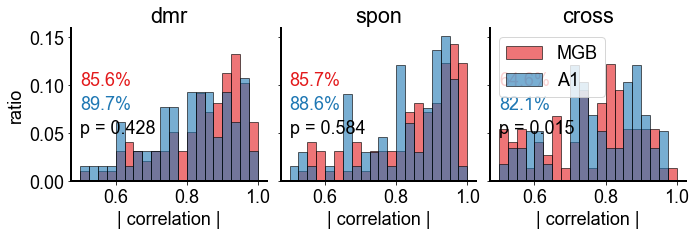

In [9]:
g = plot_sig_corr_distribution(df)
g.fig.set_size_inches(9,3)

#### comparison of correlation values under different stimulus conditions (box plot)

['MGB_dmr', 'A1_dmr', 'MGB_spon', 'A1_spon', 'MGB_cross', 'A1_cross']
significance test: MGB vs A1
MannwhitneyuResult(statistic=4045.0, pvalue=0.11126584863473588)
MannwhitneyuResult(statistic=4114.0, pvalue=0.181696336186018)
MannwhitneyuResult(statistic=2739.0, pvalue=0.1080197032818191)
significance test: dmr vs spon
MannwhitneyuResult(statistic=5096.0, pvalue=0.40567845109014833)
MannwhitneyuResult(statistic=2172.0, pvalue=0.3768658794641755)
significance test: cross vs spon/stim (MGB)
MannwhitneyuResult(statistic=2605.0, pvalue=3.4191079172904914e-09)
MannwhitneyuResult(statistic=2679.0, pvalue=1.5597108187671183e-08)
significance test: cross vs spon/stim (A1)
MannwhitneyuResult(statistic=1597.0, pvalue=0.0012878859109043683)
MannwhitneyuResult(statistic=1761.0, pvalue=0.023026116461027438)


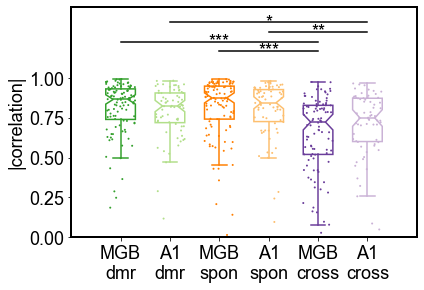

(<Figure size 432x288 with 1 Axes>, <Axes:ylabel='|correlation|'>)

In [10]:
box_scatter_sig_corr(df)

#### Scatter plot of within and cross condition values

In [11]:
df_cross = pd.concat([
df[(df.stim == 'cross') & (df.dmr_first)].merge(
    df[(df.stim == 'dmr') & (df.dmr_first)], 
    left_on=['exp', 'region', 'idx1'], right_on=['exp', 'region', 'idx2'], 
    suffixes=(None, '_dmr'), how='left').merge(
    df[(df.stim == 'spon') & (df.dmr_first)], 
    left_on=['exp', 'region','idx2'], right_on=['exp', 'region', 'idx1'], 
    suffixes=(None, '_spon'), how='left'),
df[(df.stim == 'cross') & (~df.dmr_first)].merge(
    df[(df.stim == 'dmr') & (~df.dmr_first)], 
    left_on=['exp', 'region','idx2'], right_on=['exp', 'region', 'idx1'], 
    suffixes=(None, '_dmr'), how='left').merge(
    df[(df.stim == 'spon') & (~df.dmr_first)], 
    left_on=['exp', 'region','idx1'], right_on=['exp', 'region', 'idx2'], 
    suffixes=(None, '_spon'), how='left')
])

In [12]:
df_cross.head()

,exp,probe,region,stim,dmr_first,idx1,idx2,pattern1,pattern2,corr,...,corr_sig_spon,n_neuron_spon,member1_spon,member2_spon,member_all_spon,member_share_spon,freq_span_oct_all_spon,freq_span_oct_share_spon,freq_span_oct_spon,region_stim_spon
0,210715201351,H31x64,MGB,cross,True,0,0,"[0.3677574738, 0.329001074, 0.2689638788, 0.35...","[0.3835528634, 0.18605720850000002, 0.23607617...",0.279742,...,False,9,"[0, 3, 4, 5, 8]","[2, 4]","[0, 2, 3, 4, 5, 8]",[4],5.017403,NaN,5.017403,MGB_spon
1,210805202306,H31x64,MGB,cross,True,1,2,"[0.06736965140000001, -0.0803762419, 0.0719377...","[0.0628710708, 0.020540148, -0.0417183849, -0....",0.916747,...,True,19,"[13, 14, 15, 16, 18]","[13, 14, 15, 16, 18]","[13, 14, 15, 16, 18]","[13, 14, 15, 16, 18]",NaN,NaN,3.813226,MGB_spon
2,210805202306,H31x64,MGB,cross,True,2,0,"[-0.0029846158, 0.0024098585, 0.0659382104, -0...","[-0.0275732092, -0.0090929737, 0.3390761877000...",0.881565,...,True,19,"[2, 7, 10, 11, 12]","[2, 7, 10, 11]","[2, 7, 10, 11, 12]","[2, 7, 10, 11]",0.100348,0.100348,3.813226,MGB_spon
3,210805202306,H31x64,MGB,cross,True,3,1,"[0.44269402300000005, 0.4928080179, 0.33957411...","[0.5308515336, 0.5236545201, 0.0650167047, 0.3...",0.829158,...,True,19,"[0, 1, 3, 5, 9]","[0, 1, 3, 5, 17]","[0, 1, 3, 5, 9, 17]","[0, 1, 3, 5]",3.612530,NaN,3.813226,MGB_spon
4,210401175257,H31x64,MGB,cross,True,1,1,"[0.3757793266, 0.398314577, -0.0333976806, 0.5...","[0.0680823475, 0.4251374791, -0.0087239941, 0....",0.768994,...,True,18,"[1, 3, 4, 5, 8, 15, 16]","[1, 3, 6, 16]","[1, 3, 4, 5, 6, 8, 15, 16]","[1, 3, 16]",3.411834,2.408354,3.512182,MGB_spon


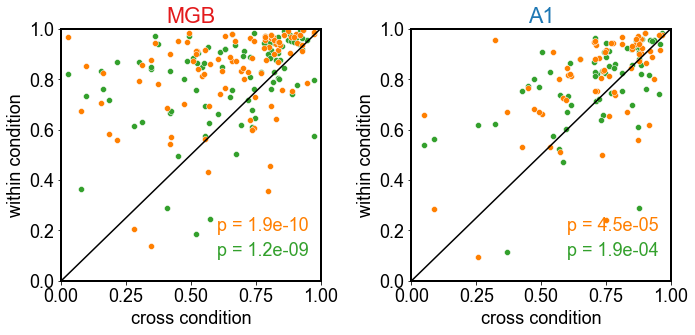

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
regions = ('MGB', 'A1')
for i in range(2):
    sns.scatterplot(data=df_cross[df_cross.region==regions[i]], 
                    x='corr', y='corr_dmr', 
                    ax=axes[i], color=colors_split[0])
    sns.scatterplot(data=df_cross[df_cross.region==regions[i]], 
                    x='corr', y='corr_spon', 
                    ax=axes[i], color=colors_split[2])
    axes[i].plot([0, 1], [0, 1], color='k')
    
    axes[i].set_xlabel('cross condition')
    axes[i].set_ylabel('within condition')
    axes[i].set_xlim([0, 1])
    axes[i].set_ylim([0, 1])
    axes[i].set_title(regions[i], color=eval('{}_color[0]'.format(regions[i])))
    
    _, p = stats.wilcoxon(x=df_cross[df_cross.region==regions[i]]['corr'], 
                          y=df_cross[df_cross.region==regions[i]]['corr_dmr'])
    axes[i].text(0.6, 0.1, 'p = {:.1e}'.format(p), color=colors_split[0])
    _, p = stats.wilcoxon(x=df_cross[df_cross.region==regions[i]]['corr'], 
                          y=df_cross[df_cross.region==regions[i]]['corr_spon'])
    axes[i].text(0.6, 0.2, 'p = {:.1e}'.format(p), color=colors_split[2])
plt.tight_layout()

#### correlation value vs total number of neurons in recording

In [14]:
df['region_sig'] = df[['region', 'corr_sig']].apply(tuple, axis=1)
df['region_sig'] = df['region_sig'].apply(lambda x: '_'.join([str(y) for y in x]))
my_order = df.groupby(by=['region', 'corr_sig'])['corr'].mean().iloc[::-1].index
my_order = ['_'.join([str(y) for y in x]) for x in my_order]
print(my_order)

['MGB_True', 'MGB_False', 'A1_True', 'A1_False']


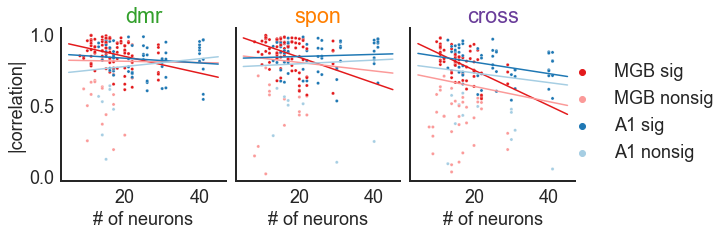

In [15]:
sns.set_style("white")
colors = MGB_color[:2] + A1_color[:2]
x = np.linspace(5, 45, 10)
g = sns.relplot(data=df, x='n_neuron', y='corr', col='stim', 
            hue='region_sig', hue_order=my_order, 
            palette=colors, s=10)
for j, ax in enumerate(g.axes[0]):
    stim = ax.get_title()[7:]
    for i, region in enumerate(['MGB', 'A1']):
        # significant values
        df_tmp = df[(df.stim == stim) & (df.region == region) & (df.corr_sig)]
        m, b = np.polyfit(df_tmp['n_neuron'], df_tmp['corr'], 1)
        ax.plot(x, m*x+b, color=colors[2*i])
        # all values
        df_tmp = df[(df.stim == stim) & (df.region == region)]
        m, b = np.polyfit(df_tmp['n_neuron'], df_tmp['corr'], 1)
        ax.plot(x, m*x+b, color=colors[2*i+1])
    ax.set_xlabel('# of neurons')
    ax.set_title(stim, color=colors_split[j*2])
g.axes[0][0].set_ylabel('|correlation|')
g.fig.set_size_inches(9,3)
for t, l in zip(g._legend.texts, ['MGB sig', 'MGB nonsig', 'A1 sig', 'A1 nonsig']):
    t.set_text(l)
sns.move_legend(g, "lower right", bbox_to_anchor=(1.1, 0.2), title=None)
plt.savefig(r'E:\Congcong\Documents\data\comparison\figure\cNE-spon_dmr_stability\corr_vs_n_neuron.png', bbox_inches='tight', dpi=300)

While all correlation values are not strongly correlated with the total number of units in the recordings, significant correlation values are negatively correlated with the total number of neurons in the recording. This reflects higher significance threshold with lower number of units. To correct for this correlation, each recording is subsampled to have only 10 neurons.

In [16]:
df_null = pd.read_json(os.path.join(datafolder, 'split_cNE_null.json'))

In [17]:
# get pattern correlation significance
df_null['corr_sig'] = df_null['corr'] > df_null['corr_thresh']
df_null.to_json(os.path.join(datafolder, 'split_cNE_null.json'))

In [18]:
df_null.head()

,exp,probe,region,stim,dmr_first,idx1,idx2,pattern1,pattern2,corr,corr_thresh,corr_sig
0,200709232021,H22x32,A1,dmr,False,0,0,"[-0.06659984420000001, -0.0105855722, 0.271157...","[0.018350159600000002, 0.0453543666, 0.4246298...",0.749968,0.783913,False
1,200709232021,H22x32,A1,dmr,False,1,1,"[0.3570798919, -0.0609886818, 0.2079867859, -0...","[-0.3369538713, 0.10175442400000001, -5.5092e-...",0.967631,0.783913,True
2,200709232021,H22x32,A1,spon,False,0,0,"[0.1319769515, -0.16307894180000002, 0.3222381...","[0.0882614995, -0.1973850465, 0.3300823392, 0....",0.906928,0.779915,True
3,200709232021,H22x32,A1,spon,False,1,1,"[-0.14889981060000002, -0.2036545729, 0.232645...","[-0.1676523006, -0.1088122489, 0.1155750278000...",0.931317,0.779915,True
4,200709232021,H22x32,A1,cross,False,0,0,"[0.0882614995, -0.1973850465, 0.3300823392, 0....","[-0.06659984420000001, -0.0105855722, 0.271157...",0.919610,0.777012,True


MGB
dmr vs spon: p = 0.1716
dmr vs cross: p = 0.0000
cross vs spon: p = 0.0000

A1
dmr vs spon: p = 0.8278
dmr vs cross: p = 0.0534
cross vs spon: p = 0.0833



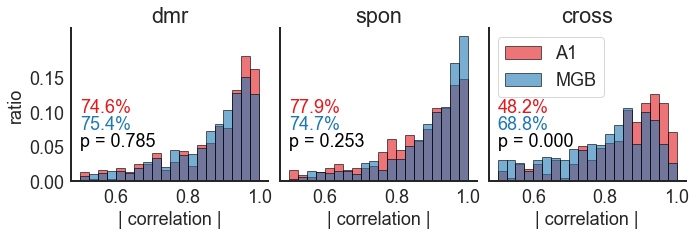

In [19]:
g = plot_sig_corr_distribution(df_null)
g.fig.set_size_inches(9,3)
g.savefig(r'E:\Congcong\Documents\data\comparison\figure\cNE-spon_dmr_stability\hist_corr_null.jpg', bbox_inches='tight')

['MGB_dmr', 'A1_dmr', 'MGB_spon', 'A1_spon', 'MGB_cross', 'A1_cross']
significance test: MGB vs A1
MannwhitneyuResult(statistic=102395.0, pvalue=0.15650798832349727)
MannwhitneyuResult(statistic=134909.0, pvalue=0.001439423244378169)
MannwhitneyuResult(statistic=66478.0, pvalue=2.2867104767569864e-14)
significance test: dmr vs spon
MannwhitneyuResult(statistic=185510.0, pvalue=0.0012362980240299157)
MannwhitneyuResult(statistic=67548.0, pvalue=0.0960435653914892)
significance test: cross vs spon/stim (MGB)
MannwhitneyuResult(statistic=97968.0, pvalue=2.4363834351683663e-51)
MannwhitneyuResult(statistic=101654.0, pvalue=2.1022260061525926e-38)
significance test: cross vs spon/stim (A1)
MannwhitneyuResult(statistic=52346.0, pvalue=0.007001018404006401)
MannwhitneyuResult(statistic=46397.0, pvalue=9.240460937547699e-06)


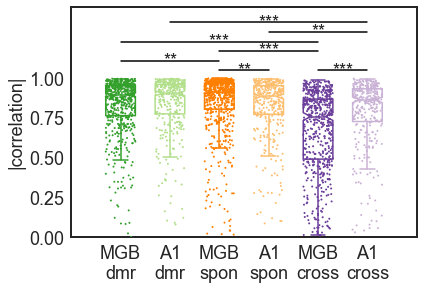

In [20]:
fig, ax = box_scatter_sig_corr(df_null)
fig.savefig(r'E:\Congcong\Documents\data\comparison\figure\cNE-spon_dmr_stability\box_corr_null.jpg', bbox_inches='tight')

#### correlation value vs frequency tuning range of the recording

In [21]:
df.head()

,exp,probe,region,stim,dmr_first,idx1,idx2,pattern1,pattern2,corr,...,n_neuron,member1,member2,member_all,member_share,freq_span_oct_all,freq_span_oct_share,freq_span_oct,region_stim,region_sig
0,210715201351,H31x64,MGB,dmr,True,1,0,"[0.0897109132, 0.4638610554, -0.0627908716, 0....","[0.3677574738, 0.329001074, 0.2689638788, 0.35...",0.614550,...,9,"[1, 6, 7]","[0, 3, 5, 6]","[0, 1, 3, 5, 6, 7]",[6],4.013923,NaN,5.017403,MGB_dmr,MGB_False
1,210715201351,H31x64,MGB,spon,True,0,1,"[0.3835528634, 0.18605720850000002, 0.23607617...","[-0.02636698, -0.1892202342, 0.5495066334, 0.3...",0.206984,...,9,"[0, 3, 4, 5, 8]","[2, 4]","[0, 2, 3, 4, 5, 8]",[4],5.017403,NaN,5.017403,MGB_spon,MGB_False
2,210715201351,H31x64,MGB,cross,True,0,0,"[0.3677574738, 0.329001074, 0.2689638788, 0.35...","[0.3835528634, 0.18605720850000002, 0.23607617...",0.279742,...,9,"[0, 3, 5, 6]","[0, 3, 4, 5, 8]","[0, 3, 4, 5, 6, 8]","[0, 3, 5]",5.017403,2.910094,5.017403,MGB_cross,MGB_False
3,210223165503,H31x64,MGB,dmr,False,0,2,"[0.3796602112, 0.4855612644, 0.439590939, 0.32...","[0.3282171698, 0.25629792230000004, 0.53166170...",0.902069,...,15,"[0, 1, 2, 3, 4]","[0, 2, 3, 4]","[0, 1, 2, 3, 4]","[0, 2, 3, 4]",1.906613,1.103829,5.318447,MGB_dmr,MGB_True
4,210223165503,H31x64,MGB,dmr,False,2,0,"[-0.26819974820000003, -0.291174998, 0.1085772...","[-0.31949930330000004, -0.2658897806, 0.056801...",0.943359,...,15,"[6, 7, 9]","[6, 7, 9]","[6, 7, 9]","[6, 7, 9]",0.301044,0.301044,5.318447,MGB_dmr,MGB_True


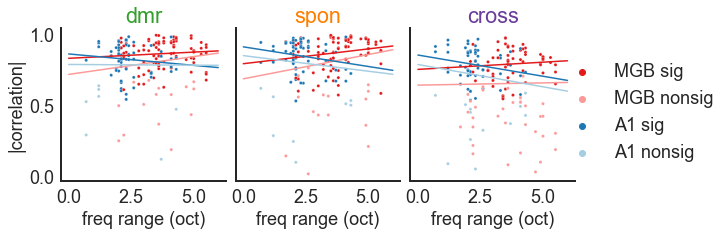

In [22]:
sns.set_style("white")
colors = MGB_color[:2] + A1_color[:2]
x = np.linspace(0, 6, 10)
g = sns.relplot(data=df, x='freq_span_oct', y='corr', col='stim', 
            hue='region_sig', hue_order=my_order, 
            palette=colors, s=10)
for j, ax in enumerate(g.axes[0]):
    stim = ax.get_title()[7:]
    for i, region in enumerate(['MGB', 'A1']):
        # significant values
        df_tmp = df[(df.stim == stim) & (df.region == region) & (df.corr_sig)]
        m, b = np.polyfit(df_tmp['freq_span_oct'], df_tmp['corr'], 1)
        ax.plot(x, m*x+b, color=colors[2*i])
        # all values
        df_tmp = df[(df.stim == stim) & (df.region == region)]
        m, b = np.polyfit(df_tmp['freq_span_oct'], df_tmp['corr'], 1)
        ax.plot(x, m*x+b, color=colors[2*i+1])
    ax.set_xlabel('freq range (oct)')
    ax.set_title(stim, color=colors_split[j*2])
g.axes[0][0].set_ylabel('|correlation|')
g.fig.set_size_inches(9,3)
for t, l in zip(g._legend.texts, ['MGB sig', 'MGB nonsig', 'A1 sig', 'A1 nonsig']):
    t.set_text(l)
sns.move_legend(g, "lower right", bbox_to_anchor=(1.1, 0.2), title=None)
plt.savefig(r'E:\Congcong\Documents\data\comparison\figure\cNE-spon_dmr_stability\corr_vs_freq_range_recording.png', bbox_inches='tight', dpi=300)

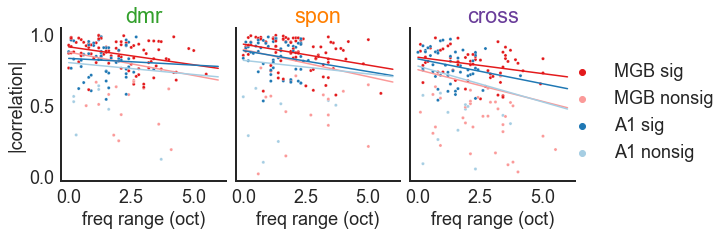

In [23]:
sns.set_style("white")
colors = MGB_color[:2] + A1_color[:2]
x = np.linspace(0, 6, 10)
g = sns.relplot(data=df, x='freq_span_oct_all', y='corr', col='stim', 
            hue='region_sig', hue_order=my_order, 
            palette=colors, s=10)
for j, ax in enumerate(g.axes[0]):
    stim = ax.get_title()[7:]
    for i, region in enumerate(['MGB', 'A1']):
        # significant values
        df_tmp = df[(df.stim == stim) & (df.region == region) & (df.corr_sig) & (~ np.isnan(df.freq_span_oct_all))]
        m, b = np.polyfit(df_tmp['freq_span_oct_all'], df_tmp['corr'], 1)
        ax.plot(x, m*x+b, color=colors[2*i])
        # all values
        df_tmp = df[(df.stim == stim) & (df.region == region) & (~ np.isnan(df.freq_span_oct_all))]
        m, b = np.polyfit(df_tmp['freq_span_oct_all'], df_tmp['corr'], 1)
        ax.plot(x, m*x+b, color=colors[2*i+1])
    ax.set_xlabel('freq range (oct)')
    ax.set_title(stim, color=colors_split[j*2])
g.axes[0][0].set_ylabel('|correlation|')
g.fig.set_size_inches(9,3)
for t, l in zip(g._legend.texts, ['MGB sig', 'MGB nonsig', 'A1 sig', 'A1 nonsig']):
    t.set_text(l)
sns.move_legend(g, "lower right", bbox_to_anchor=(1.1, 0.2), title=None)
plt.savefig(r'E:\Congcong\Documents\data\comparison\figure\cNE-spon_dmr_stability\corr_vs_freq_range_member_all.png', bbox_inches='tight', dpi=300)